In [2]:
import numpy as np
import os
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from collections import Counter
import random
from tqdm import tqdm  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import cv2

In [1]:
!python /kaggle/input/cropper/Cropper.py \
  --root-dir /kaggle/input/stanford-car-dataset-by-classes-folder \
  --output-dir /kaggle/working/cropped_images \
  --show-classes 20


Found 196 classes, 8144 images total.
  0: AM General Hummer SUV 2000     →   45 images
  1: Acura Integra Type R 2001      →   45 images
  2: Acura RL Sedan 2012            →   32 images
  3: Acura TL Sedan 2012            →   43 images
  4: Acura TL Type-S 2008           →   42 images
  5: Acura TSX Sedan 2012           →   41 images
  6: Acura ZDX Hatchback 2012       →   39 images
  7: Aston Martin V8 Vantage Convertible 2012 →   45 images
  8: Aston Martin V8 Vantage Coupe 2012 →   41 images
  9: Aston Martin Virage Convertible 2012 →   33 images
 10: Aston Martin Virage Coupe 2012 →   38 images
 11: Audi 100 Sedan 1994            →   41 images
 12: Audi 100 Wagon 1994            →   43 images
 13: Audi A5 Coupe 2012             →   41 images
 14: Audi R8 Coupe 2012             →   43 images
 15: Audi RS 4 Convertible 2008     →   37 images
 16: Audi S4 Sedan 2007             →   45 images
 17: Audi S4 Sedan 2012             →   40 images
 18: Audi S5 Convertible 2012       →   42

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

data_dir = '/kaggle/working/cropped_images'

train_transform = transforms.Compose([
    transforms.Resize([224 , 224]),
    transforms.RandomHorizontalFlip(p=0.5),   # random flip :contentReference[oaicite:1]{index=1}
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize([224 , 224]), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

cuda is available


In [24]:
full_dataset = datasets.ImageFolder(root=data_dir , transform=None)
num_classes = len(full_dataset.classes)
total_size = len(full_dataset)


train_val_size = int(0.8 * len(full_dataset))
test_size      = len(full_dataset) - train_val_size
train_val_ds, test_ds = random_split(full_dataset, [train_val_size, test_size])

train_size = int(0.7 * len(train_val_ds))
val_size   = len(train_val_ds) - train_size
train_ds, val_ds = random_split(train_val_ds, [train_size, val_size])

# 4) _Then_ assign transforms on the underlying ImageFolder_
train_ds.dataset.transform = train_transform
val_ds.dataset.transform   = test_transform
test_ds.dataset.transform  = test_transform

# 5) Now create loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=64 , shuffle=False, num_workers=4)

In [25]:
# Display dataset information
print(f'Total Classes: {num_classes}')
print(f'Total Samples: {total_size}')
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')

Total Classes: 196
Total Samples: 8144
Train size: 4560
Validation size: 1955
Test size: 1629


In [26]:
# Self-Attention Model
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        c_q = in_channels // 8
        self.query = nn.Conv2d(in_channels, c_q, kernel_size=1)
        self.key   = nn.Conv2d(in_channels, c_q, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        N, C, H, W = x.shape
        M = H * W

        # project and flatten spatial dims
        q = self.query(x).view(N,    C//8, M).permute(0,2,1)  # → (N, M, C_q)
        k = self.key(x).view( N,    C//8, M).permute(0,2,1)   # → (N, M, C_q)
        v = self.value(x).view(N,     C, M).permute(0,2,1)    # → (N, M, C)

        # compute attention over spatial positions
        attn = torch.softmax( (q @ k.transpose(-1,-2)) / (C//8)**0.5, dim=-1 )
        # → (N, M, M)

        # re-weight the values
        out = attn @ v   # → (N, M, C)
        out = out.permute(0,2,1).view(N, C, H, W)
        return out

# Bilinear CNN with Attention Model
class BilinearCNNWithAttention(nn.Module):
    def __init__(self, num_classes=196, dropout_rate=0.6):
        super(BilinearCNNWithAttention, self).__init__()
        backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in backbone.parameters():
            param.requires_grad = False

        # Make only the last layer (layer4) trainable
        for param in backbone.layer4.parameters():
            param.requires_grad = True
        for param in backbone.layer3.parameters():
            param.requires_grad = True
        for param in backbone.layer2.parameters():
            param.requires_grad = True
        
        
        # Extract features from the pre-trained ResNet50 backbone, excluding avgpool and fc layers
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.attention = SelfAttention(in_channels=2048)  
        self.reduce_dim = nn.Conv2d(2048, 512, kernel_size=1) 
        self.dropout = nn.Dropout(p=dropout_rate)  
        self.fc = nn.Linear(512 * 512, num_classes)
       

    def forward(self, x):
        
        x = self.features(x)           
        x = self.attention(x)          
        x = self.reduce_dim(x)         
        x = x.view(x.size(0), 512, -1) 
        x = torch.bmm(x, x.transpose(1, 2)) / x.size(2) 
        x = x.view(x.size(0), -1)      
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)  
        x = nn.functional.normalize(x)  
        x = self.dropout(x)  
        x = self.fc(x)  
        return x

In [27]:
# New model with Attention
# model_attention = BilinearCNNWithAttention(num_classes=num_classes).to(device)

model_attention = BilinearCNNWithAttention(num_classes=num_classes)

if torch.cuda.device_count() > 1:
    print(f"→ Using {torch.cuda.device_count()} GPUs")
    model_attention = nn.DataParallel(model_attention)

model_attention = model_attention.to(device)  # typically device = torch.device("cuda")

#  Loss function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam([
    {'params': model_attention.module.features[:5].parameters(), 'lr': 1e-5},
    {'params': model_attention.module.features[5:].parameters(), 'lr': 1e-4},
    {'params': model_attention.module.fc.parameters(),               'lr': 1e-3},
], weight_decay=1e-3)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience  
        self.min_delta = min_delta  
        self.counter = 0 
        
        self.best_loss = None  
        self.early_stop = False  

    def __call__(self, val_loss):
        
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

#Training the model with Attention
train_losses, val_losses = [], []
num_epochs = 40
for epoch in range(num_epochs):
    model_attention.train()  
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_attention(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model_attention.eval()  
    val_running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_attention(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Step the learning 
    scheduler.step(val_loss)
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


→ Using 2 GPUs
Epoch [1/40] → Train Loss: 4.8074 | Val Loss: 4.1705
Epoch [2/40] → Train Loss: 3.7799 | Val Loss: 3.5964
Epoch [3/40] → Train Loss: 3.2461 | Val Loss: 3.3321
Epoch [4/40] → Train Loss: 2.9187 | Val Loss: 3.1077
Epoch [5/40] → Train Loss: 2.6895 | Val Loss: 2.9895
Epoch [6/40] → Train Loss: 2.5353 | Val Loss: 2.8523
Epoch [7/40] → Train Loss: 2.3981 | Val Loss: 2.7908
Epoch [8/40] → Train Loss: 2.2887 | Val Loss: 2.6987
Epoch [9/40] → Train Loss: 2.2109 | Val Loss: 2.6772
Epoch [10/40] → Train Loss: 2.1294 | Val Loss: 2.5859
Epoch [11/40] → Train Loss: 2.0893 | Val Loss: 2.5862
Epoch [12/40] → Train Loss: 2.0311 | Val Loss: 2.5479
Epoch [13/40] → Train Loss: 1.9958 | Val Loss: 2.5369
Epoch [14/40] → Train Loss: 1.9479 | Val Loss: 2.5410
Epoch [15/40] → Train Loss: 1.9267 | Val Loss: 2.5068
Epoch [16/40] → Train Loss: 1.9060 | Val Loss: 2.4979
Epoch [17/40] → Train Loss: 1.8734 | Val Loss: 2.5243
Epoch [18/40] → Train Loss: 1.8703 | Val Loss: 2.5013
Epoch [19/40] → Train 


Performance on Validation Set:
Accuracy:  0.7217
Top-5 Accuracy:  0.9371
Precision: 0.7243
Recall:    0.7332
F1-Score:  0.7010
Balanced Accuracy: 0.7217


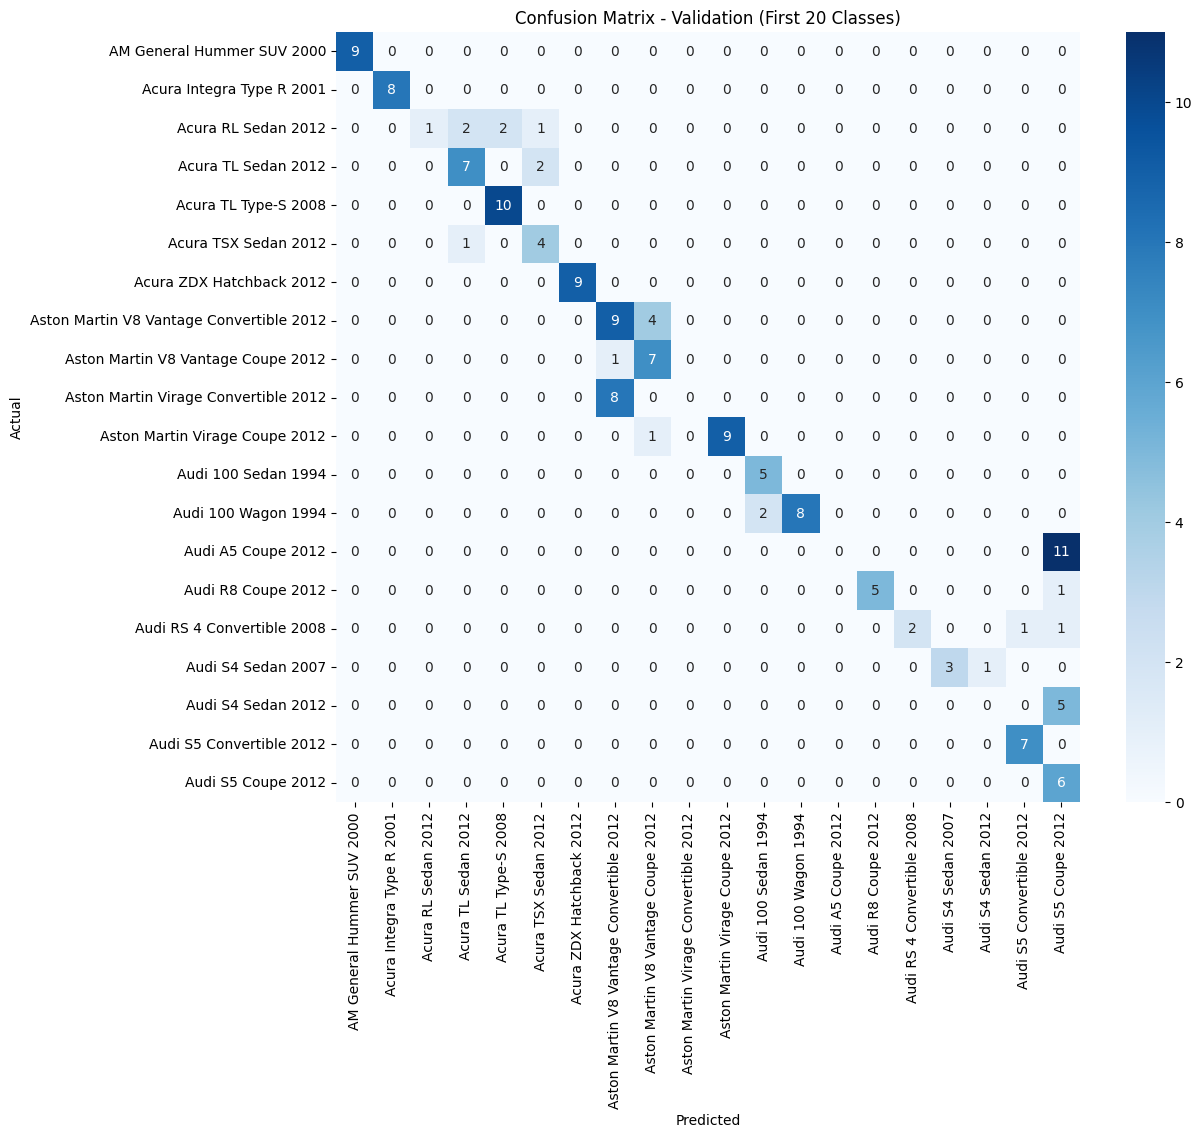


Performance on Test Set:
Accuracy:  0.7471
Top-5 Accuracy:  0.9478
Precision: 0.7378
Recall:    0.7498
F1-Score:  0.7199
Balanced Accuracy: 0.7471


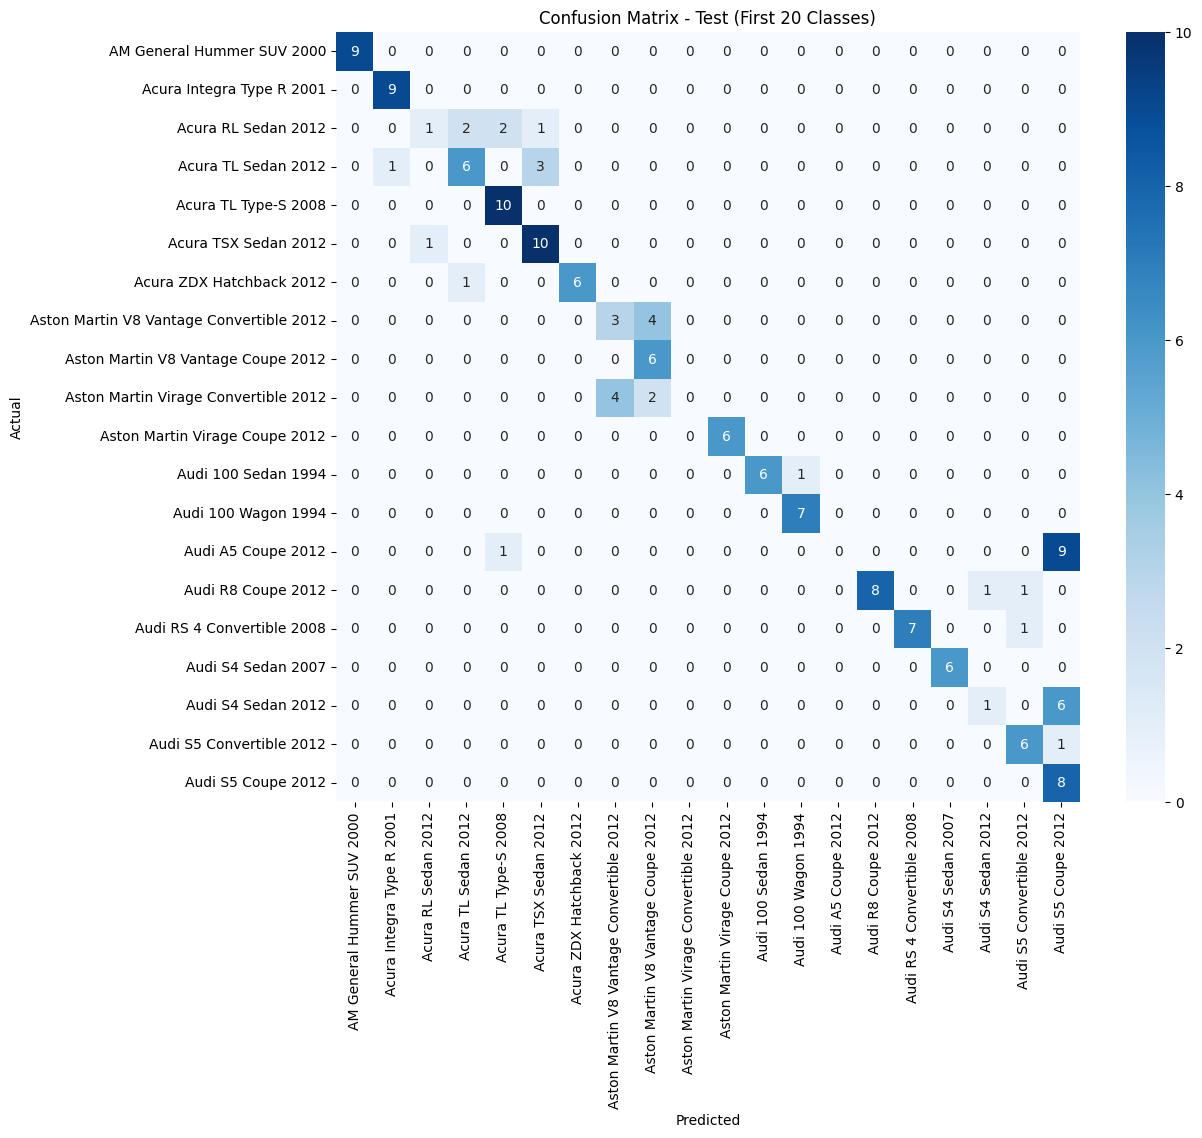

In [28]:
# Function to evaluate the model performance
def evaluate_model(model, dataloader, dataset_name):
    model.eval()  
    
    # Lists to store all predictions, true labels, and top-5 predictions
    all_preds = []
    all_labels = []
    top5_preds = []

    with torch.no_grad():  
        # Loop through the dataloader to get batches of images and labels
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, preds = torch.max(outputs, 1)  

            # For Top-5 Accuracy
            _, top5 = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)  

            # Store the predictions, true labels, and top 5 predictions
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())
            top5_preds.extend(top5.cpu().numpy())

    # Calculate performance metrics
    acc = accuracy_score(all_labels, all_preds)  
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)  
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)  
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)  
    
    # Calculate Top-5 Accuracy
    top5_acc = np.mean([1 if lbl in top5 else 0 for lbl, top5 in zip(all_labels, top5_preds)])

    # Calculate Balanced Accuracy 
    balanced_acc = np.mean([accuracy_score([lbl], [lbl_pred]) for lbl, lbl_pred in zip(all_labels, all_preds)])

    # Print out the performance metrics
    print(f"\nPerformance on {dataset_name} Set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Top-5 Accuracy:  {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Display confusion matrix for the first 20 classes
    cm = confusion_matrix(all_labels, all_preds)  
    plt.figure(figsize=(12, 10))  
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',  
                xticklabels=full_dataset.classes[:20], 
                yticklabels=full_dataset.classes[:20])  
    plt.title(f"Confusion Matrix - {dataset_name} (First 20 Classes)")  
    plt.xlabel("Predicted")  
    plt.ylabel("Actual")  
    plt.show()  

# Evaluate on the Validation set
evaluate_model(model_attention, val_loader, "Validation")

# Evaluate on the Test set
evaluate_model(model_attention, test_loader, "Test")

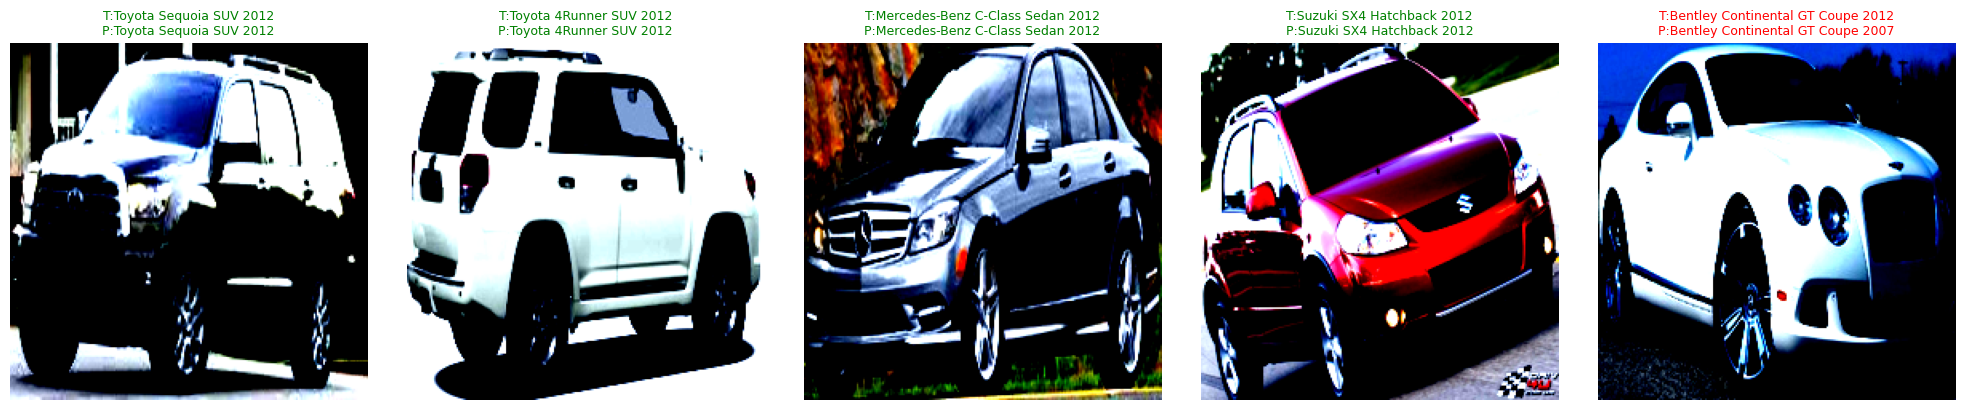

In [15]:
def show_random_predictions(model, dataset, class_names, device, num_images=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_img = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_img)
            _, pred = torch.max(output, 1)

        true_label = class_names[label]
        predicted_label = class_names[pred.item()]

        color = 'green' if pred.item() == label else 'red'

        axes[i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(f"T:{true_label}\nP:{predicted_label}", color=color, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

class_names = full_dataset.classes

show_random_predictions(model_attention, test_ds, class_names, device, num_images=5)